### The target variable denoted as Bad_label.

 - If value is 0: it means customer has good credit history 
 - If value is 1: it means customer has falls into 30 DPD + bucket

# Notes


## Final Data
- Dropping  feature_8 feature_9 feature_13 feature_48 feature_51 feature_53 feature_57 feature_73 feature_74 Due to large number of missing values
- drop date "feature_30","feature_39"


## Drop
#### Account
- Drop paymenthistory1, paymenthistory2 because of misleading data. or in future remove xxxx
- drop paymentfrequency (high missing value).

#### Current
- "feature_5","feature_6" both contain single value  
- feature_14 contains 0 & 12
- "feature_15","feature_16","feature_17","feature_18" contain mix of string and integer value
- "feature_20","feature_22","feature_24","feature_29","feature_44","feature_45","feature_47","feature_49","feature_61","feature_66","feature_77" not contain useful value

- all unnamed features which includes dates are dropped until we know the date labels
- Due to avoid model complexity removing column having  lage number of missing values

# Train Data set

In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
from functools import reduce

useless_col_E = ["upload_dt","dt_opened","enquiry_dt"] # not considering dates in prediction analysis
enquiry = pd.read_csv("E:/Tookitaki/test data/raw_enquiry_70_new.csv",low_memory=False).drop(useless_col_E, 1)

group9=pd.DataFrame(enquiry.groupby(["customer_no"])["enq_purpose"].median())
group10=pd.DataFrame(enquiry.groupby(["customer_no"])["enq_amt"].sum())

dfs_E = [group9,group10]
df_final_E = reduce(lambda left,right: pd.merge(left,right,on='customer_no'), dfs_E)
df_final_E=df_final_E.reset_index(level='customer_no')

## Account

In [2]:
useless_col_A = ["paymenthistory1","paymenthistory2","paymentfrequency","upload_dt","dt_opened"]
account = pd.read_csv("E:/Tookitaki/test data/raw_account_70_new.csv",low_memory=False).drop(useless_col_A, 1)

# extracting number of days from date features
account["diff_open_close"]=(pd.to_datetime(account["closed_dt"])-pd.to_datetime(account["opened_dt"])).dt.days
account["diff_paymnt_strt_end"]=(pd.to_datetime(account["paymt_end_dt"])-pd.to_datetime(account["paymt_str_dt"])).dt.days
account["diff_lstpaym_report_dt"]=(pd.to_datetime(account["last_paymt_dt"])-pd.to_datetime(account["reporting_dt"])).dt.days

drop_cols_A=["closed_dt","opened_dt","paymt_end_dt","paymt_str_dt","last_paymt_dt","reporting_dt"]
account = account.drop(drop_cols_A, axis = 1)

group=pd.DataFrame(account.groupby(["customer_no"])["actualpaymentamount"].sum())
group1=pd.DataFrame(account.groupby(["customer_no"])["rateofinterest"].mean())
group2=pd.DataFrame(account.groupby(["customer_no"])["cashlimit"].mean())
group3=pd.DataFrame(account.groupby(["customer_no"])["creditlimit"].mean())
group4=pd.DataFrame(account.groupby(["customer_no"])["amt_past_due"].sum())
group5=pd.DataFrame(account.groupby(["customer_no"])["cur_balance_amt"].sum())
group6=pd.DataFrame(account.groupby(["customer_no"])["high_credit_amt"].mean())
group7=pd.DataFrame(account.groupby(["customer_no"])["acct_type"].median())
group8=pd.DataFrame(account.groupby(["customer_no"])["owner_indic"].median())

dfs_A = [group,group1,group2,group3,group4,group5,group6,group7,group8]
df_final_A = reduce(lambda left,right: pd.merge(left,right,on='customer_no'), dfs_A)

df_final_A=df_final_A.reset_index(level='customer_no')

## Current

In [3]:
useless_col_C=["feature_2","feature_5","feature_6","feature_8","feature_9","feature_13","feature_10","feature_14",
               "feature_15","feature_16","feature_17","feature_18","feature_20","feature_21","feature_22","feature_24",
               "feature_29","feature_30","feature_39","feature_44","feature_45","feature_47","feature_48","feature_49",
               "feature_51","feature_53","feature_54","feature_57","feature_61","feature_63","feature_66","feature_70",
               "feature_73","feature_74","feature_75","feature_77"]
current = pd.read_csv("E:/Tookitaki/test data/raw_data_70_new.csv").drop(useless_col_C, axis=1)

current["Active_cust"] = (pd.to_datetime(current["dt_opened"])-pd.to_datetime(current["entry_time"])).dt.days
drop_cols_C=["dt_opened","entry_time"]
current = current.drop(drop_cols_C, axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Final

In [4]:
df_final=current.merge(df_final_A,on="customer_no").merge(df_final_E,on="customer_no")

# back filling is best method to suit few number of missing values in float and object
df_final.loc[:,'feature_1':'feature_4'] = df_final.loc[:,'feature_1':'feature_4'].fillna(method="bfill")
df_final.loc[:,'feature_11':'feature_68'] = df_final.loc[:,'feature_11':'feature_68'].fillna(method="bfill")
df_final.loc[:,'feature_71':'feature_79'] = df_final.loc[:,'feature_71':'feature_79'].fillna(method="bfill")
df_final["feature_7"]=df_final["feature_7"].fillna(df_final["feature_7"].mean())
df_final["Active_cust"]=df_final["Active_cust"].fillna(method="bfill")
df_final[["feature_69","rateofinterest","cashlimit","creditlimit",
          "high_credit_amt","enq_purpose"]]=df_final[["feature_69","rateofinterest","cashlimit",
                                                      "creditlimit","high_credit_amt","enq_purpose"]].fillna(value=0)
# converting float to int64 for categories
for col in df_final.loc[:,'feature_1':'feature_79'].columns:
        if df_final[col].dtype == 'float64':
            df_final[col] = df_final[col].astype('int64')


df_final[["Active_cust","cashlimit","creditlimit","enq_purpose"]] = df_final[["Active_cust","cashlimit",
                                                                              "creditlimit","enq_purpose"]].astype("int64")
# moving Bad-label to the end of dataframe
df1 = df_final.pop('Bad_label')
df_final['Bad_label']=df1
# only 2 records were missing from each column so,
df_final['feature_37'] = df_final['feature_37'].fillna("Private Ltd. Co.")
df_final['feature_36'] = df_final['feature_36'].fillna("Health Care")
df_final['feature_38'] = df_final['feature_38'].fillna("SENIOR ANALYST")

In [5]:
df_final.head(15)

,customer_no,feature_1,feature_3,feature_4,feature_7,feature_11,feature_12,feature_19,feature_23,feature_25,...,cashlimit,creditlimit,amt_past_due,cur_balance_amt,high_credit_amt,acct_type,owner_indic,enq_purpose,enq_amt,Bad_label
0,1,Insignia,650,2,500000,Y,IS1,1,N,1,...,168000,335000,2538209.0,4714857,5.266709e+05,6.0,1.0,10,4.981150e+06,0
1,2,Insignia,760,1,1200000,Y,IS1,1,N,1,...,1,1000000,0.0,30754,5.587975e+05,10.0,1.0,51,6.676682e+09,0
2,3,Insignia,774,1,700000,Y,IS1,2,N,1,...,0,0,0.0,17864,1.215230e+05,10.0,1.0,1,3.400000e+06,0
3,4,Insignia,770,1,500000,Y,IS1,1,N,1,...,120333,318666,0.0,1845569,8.203109e+05,10.0,1.0,5,5.081000e+07,0
4,5,Insignia,779,3,500000,Y,IS1,1,N,1,...,0,0,0.0,7973,3.204376e+06,10.0,1.0,10,2.000000e+03,0
5,6,Insignia,779,1,1000000,Y,IS1,1,N,1,...,135000,434500,1103.0,23795581,2.703064e+06,5.0,1.0,2,1.356240e+08,0
6,7,Insignia,762,1,100000,Y,IS2,1,N,1,...,57950,113000,0.0,51154,3.494317e+04,10.0,1.0,10,5.000000e+04,0
7,8,Insignia,799,1,357000,Y,IS2,1,N,1,...,62250,114600,0.0,14029079,1.708902e+06,10.0,1.0,1,1.793002e+08,0
8,9,Insignia,762,1,550000,Y,IS2,1,N,1,...,33667,206000,0.0,14126636,3.357386e+06,10.0,2.0,1,1.744300e+08,1
9,10,Insignia,784,1,1017000,Y,IS2,1,N,1,...,243000,405000,0.0,247719,8.287800e+05,10.0,1.0,1,1.144927e+08,0


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23896 entries, 0 to 23895
Data columns (total 57 columns):
customer_no            23896 non-null int64
feature_1              23896 non-null object
feature_3              23896 non-null int64
feature_4              23896 non-null int64
feature_7              23896 non-null int64
feature_11             23896 non-null object
feature_12             23896 non-null object
feature_19             23896 non-null int64
feature_23             23896 non-null object
feature_25             23896 non-null int64
feature_26             23896 non-null int64
feature_27             23896 non-null object
feature_28             23896 non-null object
feature_31             23896 non-null int64
feature_32             23896 non-null object
feature_33             23896 non-null object
feature_34             23896 non-null int64
feature_35             23896 non-null int64
feature_36             23896 non-null object
feature_37             23896 non-null object
f

# Test Data Preprocessing

In [7]:
## Enquiry
useless_col_E_test = ["upload_dt","dt_opened","enquiry_dt"]
enquiry_test = pd.read_csv("E:/Tookitaki/test data/raw_enquiry_30_new.csv",low_memory=False).drop(useless_col_E_test, 1)

group9_test=pd.DataFrame(enquiry_test.groupby(["customer_no"])["enq_purpose"].median())
group10_test=pd.DataFrame(enquiry_test.groupby(["customer_no"])["enq_amt"].sum())

dfs_E_test = [group9_test,group10_test]
df_final_E_test = reduce(lambda left,right: pd.merge(left,right,on='customer_no'), dfs_E_test)
df_final_E_test=df_final_E_test.reset_index(level='customer_no')

## Account

useless_col_A_test = ["paymenthistory1","paymenthistory2","paymentfrequency","upload_dt","dt_opened"]
account_test = pd.read_csv("E:/Tookitaki/test data/raw_account_30_new.csv",low_memory=False).drop(useless_col_A_test, 1)

account_test["diff_open_close"]=(pd.to_datetime(account_test["closed_dt"])-pd.to_datetime(account_test["opened_dt"])).dt.days
account_test["diff_paymnt_strt_end"]=(pd.to_datetime(account_test["paymt_end_dt"])-pd.to_datetime(account_test["paymt_str_dt"])).dt.days
account_test["diff_lstpaym_report_dt"]=(pd.to_datetime(account_test["last_paymt_dt"])-pd.to_datetime(account_test["reporting_dt"])).dt.days

drop_cols_A_test=["closed_dt","opened_dt","paymt_end_dt","paymt_str_dt","last_paymt_dt","reporting_dt"]
account_test = account_test.drop(drop_cols_A_test, axis = 1)

group_test=pd.DataFrame(account_test.groupby(["customer_no"])["actualpaymentamount"].sum())
group1_test=pd.DataFrame(account_test.groupby(["customer_no"])["rateofinterest"].mean())
group2_test=pd.DataFrame(account_test.groupby(["customer_no"])["cashlimit"].mean())
group3_test=pd.DataFrame(account_test.groupby(["customer_no"])["creditlimit"].mean())
group4_test=pd.DataFrame(account_test.groupby(["customer_no"])["amt_past_due"].sum())
group5_test=pd.DataFrame(account_test.groupby(["customer_no"])["cur_balance_amt"].sum())
group6_test=pd.DataFrame(account_test.groupby(["customer_no"])["high_credit_amt"].mean())
group7_test=pd.DataFrame(account_test.groupby(["customer_no"])["acct_type"].median())
group8_test=pd.DataFrame(account_test.groupby(["customer_no"])["owner_indic"].median())

dfs_A_test = [group_test,group1_test,group2_test,group3_test,group4_test,group5_test,group6_test,group7_test,group8_test]
df_final_A_test = reduce(lambda left,right: pd.merge(left,right,on='customer_no'), dfs_A_test)

df_final_A_test=df_final_A_test.reset_index(level='customer_no')

## Current

useless_col_C_test=["feature_2","feature_5","feature_6","feature_8","feature_9","feature_13","feature_10","feature_14",
                    "feature_15","feature_16","feature_17","feature_18","feature_20","feature_21","feature_22","feature_24",
                    "feature_29","feature_30","feature_39","feature_44","feature_45","feature_47","feature_48","feature_49",
                    "feature_51","feature_53","feature_54","feature_57","feature_61","feature_63","feature_66","feature_70",
                    "feature_73","feature_74","feature_75","feature_77"]

current_test = pd.read_csv("E:/Tookitaki/test data/raw_data_30_new.csv").drop(useless_col_C_test, axis=1)

current_test["Active_cust"] = (pd.to_datetime(current_test["dt_opened"])-pd.to_datetime(current_test["entry_time"])).dt.days

drop_cols_C_test=["dt_opened","entry_time"]
current_test = current_test.drop(drop_cols_C_test, axis = 1)

## Final

df_final_test=current_test.merge(df_final_A_test,on="customer_no").merge(df_final_E_test,on="customer_no")

df_final_test.loc[:,'feature_1':'feature_4'] = df_final_test.loc[:,'feature_1':'feature_4'].fillna(method="bfill")
df_final_test.loc[:,'feature_11':'feature_68'] = df_final_test.loc[:,'feature_11':'feature_68'].fillna(method="bfill")
df_final_test.loc[:,'feature_71':'feature_79'] = df_final_test.loc[:,'feature_71':'feature_79'].fillna(method="bfill")
df_final_test["feature_7"]=df_final_test["feature_7"].fillna(df_final_test["feature_7"].mean())
df_final_test["Active_cust"]=df_final_test["Active_cust"].fillna(method="bfill")
df_final_test[["feature_69","rateofinterest","cashlimit","creditlimit",
               "high_credit_amt","enq_purpose"]]=df_final_test[["feature_69","rateofinterest","cashlimit",
                                                           "creditlimit","high_credit_amt","enq_purpose"]].fillna(value=0)

for col in df_final_test.loc[:,'feature_1':'feature_79'].columns:
        if df_final_test[col].dtype == 'float64':
            df_final_test[col] = df_final_test[col].astype('int64')

df_final_test[["Active_cust","cashlimit","creditlimit","enq_purpose"]] = df_final_test[["Active_cust","cashlimit","creditlimit",
                                                                                        "enq_purpose"]].astype("int64")

df1_test = df_final_test.pop('Bad_label') # remove column x and store it in df2
df_final_test['Bad_label']=df1_test

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_final_test.head(15)

,customer_no,feature_1,feature_3,feature_4,feature_7,feature_11,feature_12,feature_19,feature_23,feature_25,...,cashlimit,creditlimit,amt_past_due,cur_balance_amt,high_credit_amt,acct_type,owner_indic,enq_purpose,enq_amt,Bad_label
0,1,Insignia,726,1,1200000,Y,IS1,2,N,1,...,70125,620800,0.0,92107267,9.810434e+06,10.0,2.0,2,2.012412e+09,0
1,2,Insignia,844,1,300000,Y,IS1,2,N,1,...,0,0,0.0,-76,2.901700e+04,10.0,1.0,10,5.100000e+04,0
2,3,Insignia,723,3,1500000,Y,IS2,1,N,1,...,259200,498000,2608.0,19327294,4.506545e+06,2.0,1.0,2,2.005362e+08,0
3,4,Insignia,778,1,2500000,Y,IS2,1,N,1,...,434470,1156250,0.0,11408537,2.142191e+06,10.0,1.0,5,1.271378e+09,0
4,5,Insignia,810,1,500000,Y,IS1,1,N,1,...,115000,192000,2393.0,46240,1.487038e+05,10.0,1.0,10,1.120200e+07,0
5,6,Insignia,601,2,500000,Y,IS1,1,N,2,...,65600,1025000,32110.0,33419539,1.094319e+07,10.0,1.5,3,4.612020e+08,0
6,7,Insignia,712,1,1000000,Y,IS1,1,N,1,...,0,1000000,0.0,126017,4.317515e+05,8.0,1.0,10,1.322010e+05,0
7,8,Insignia,620,2,1000000,Y,IS1,1,N,1,...,133958,236000,21710.0,630497,2.460837e+05,10.0,1.0,10,4.830000e+05,0
8,9,Insignia,772,1,500000,Y,IS1,1,N,1,...,20000,30000,0.0,3700,2.109400e+04,10.0,1.0,10,3.274660e+08,0
9,10,Platinum Maxima,702,3,100000,Y,PM1,1,Y,1,...,37216,98812,0.0,2014732,1.937514e+05,10.0,1.0,5,2.238014e+07,0


In [9]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10240 entries, 0 to 10239
Data columns (total 57 columns):
customer_no            10240 non-null int64
feature_1              10240 non-null object
feature_3              10240 non-null int64
feature_4              10240 non-null int64
feature_7              10240 non-null int64
feature_11             10240 non-null object
feature_12             10240 non-null object
feature_19             10240 non-null int64
feature_23             10240 non-null object
feature_25             10240 non-null int64
feature_26             10240 non-null int64
feature_27             10240 non-null object
feature_28             10240 non-null object
feature_31             10240 non-null int64
feature_32             10240 non-null object
feature_33             10240 non-null object
feature_34             10240 non-null int64
feature_35             10240 non-null int64
feature_36             10240 non-null object
feature_37             10240 non-null object
f

# Object Label Encoding (Train Data)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,df_final.shape[1]):
    if df_final.dtypes[i]=='object':
        df_final[df_final.columns[i]] = le.fit_transform(df_final[df_final.columns[i]])

In [11]:
df_final.head()

,customer_no,feature_1,feature_3,feature_4,feature_7,feature_11,feature_12,feature_19,feature_23,feature_25,...,cashlimit,creditlimit,amt_past_due,cur_balance_amt,high_credit_amt,acct_type,owner_indic,enq_purpose,enq_amt,Bad_label
0,1,1,650,2,500000,1,3,1,0,1,...,168000,335000,2538209.0,4714857,5.266709e+05,6.0,1.0,10,4.981150e+06,0
1,2,1,760,1,1200000,1,3,1,0,1,...,1,1000000,0.0,30754,5.587975e+05,10.0,1.0,51,6.676682e+09,0
2,3,1,774,1,700000,1,3,2,0,1,...,0,0,0.0,17864,1.215230e+05,10.0,1.0,1,3.400000e+06,0
3,4,1,770,1,500000,1,3,1,0,1,...,120333,318666,0.0,1845569,8.203109e+05,10.0,1.0,5,5.081000e+07,0
4,5,1,779,3,500000,1,3,1,0,1,...,0,0,0.0,7973,3.204376e+06,10.0,1.0,10,2.000000e+03,0


# Object Label Encoding (Test Data)

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,df_final_test.shape[1]):
    if df_final_test.dtypes[i]=='object':
        df_final_test[df_final_test.columns[i]] = le.fit_transform(df_final_test[df_final_test.columns[i]])

In [13]:
#Getting target variable
Y_train = df_final['Bad_label'].astype('category')
Y_test = df_final_test['Bad_label'].astype('category')
#Join labeled data and standardised data to get Explanatory variables 
X_train = df_final.iloc[:, 1:].drop('Bad_label',axis=1)
X_test = df_final_test.iloc[:, 1:].drop('Bad_label',axis=1)

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
X_test

array([[-2.65425382e+00,  7.01950475e-02, -1.48024882e+00, ...,
         4.44818644e+00, -2.51524323e+00,  1.78685664e+01],
       [-2.65425382e+00,  3.19909277e+00, -1.48024882e+00, ...,
        -1.03525932e-01,  4.84064494e-01, -1.27685505e-01],
       [-2.65425382e+00, -9.35319963e-03,  7.59904807e-01, ...,
        -1.03525932e-01, -2.51524323e+00,  1.66522450e+00],
       ...,
       [ 1.58103887e+00,  7.01950475e-02, -1.48024882e+00, ...,
        -1.03525932e-01,  4.84064494e-01, -1.26102620e-01],
       [-9.60136742e-01,  3.35355871e-01,  7.59904807e-01, ...,
        -1.03525932e-01,  4.84064494e-01, -1.26666020e-01],
       [-1.13078203e-01,  1.71628827e-02,  7.59904807e-01, ...,
        -1.03525932e-01,  4.84064494e-01, -1.06565255e-01]])

# Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
y_pred = classifier.predict(X_test)

In [18]:
print("Training set score: {:.3f}".format(classifier.score(X_train, Y_train)))
print("Test set score: {:.3f}".format(classifier.score(X_test, Y_test)))

Training set score: 0.958
Test set score: 0.955


In [19]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(LogisticRegression(), X_train, Y_train, scoring='accuracy', cv=8)
print (scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0.95716198 0.95749665 0.95783133 0.95749665 0.95813798 0.95813798
 0.95813798 0.95813798]


In [20]:
print (scores.mean())

0.9578173152534227


In [21]:
print (scores.std())

0.00036169799808248836


C:\ProgramData\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


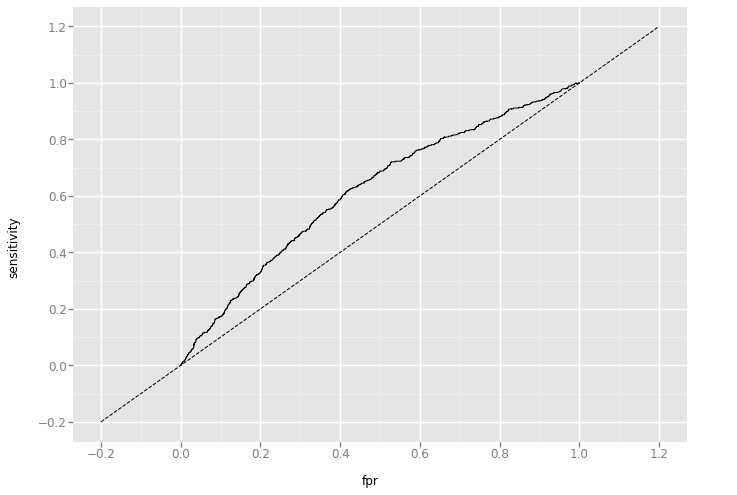

<ggplot: (9401755)>

In [22]:
from sklearn import metrics
from ggplot import *
from pandas import Timestamp

prob = classifier.predict_proba(X_test)[:,1]
fpr, sensitivity, _ = metrics.roc_curve(Y_test, prob)

df = pd.DataFrame(dict(fpr=fpr, sensitivity=sensitivity))
ggplot(df, aes(x='fpr', y='sensitivity')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

In [23]:
auc = metrics.auc(fpr,sensitivity)
auc

0.6175472104087363

In [24]:
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1").fit(X_train, Y_train)
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_train, Y_train)))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_test, Y_test)))

Training accuracy of l1 logreg with C=0.001: 0.96
Test accuracy of l1 logreg with C=0.001: 0.95
Training accuracy of l1 logreg with C=1.000: 0.96
Test accuracy of l1 logreg with C=1.000: 0.95
Training accuracy of l1 logreg with C=100.000: 0.96
Test accuracy of l1 logreg with C=100.000: 0.95


# K Neighbor

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=2)
knn1.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [30]:
from sklearn.metrics import confusion_matrix
y_predk1 = knn1.predict(X_test)
cmk1 = confusion_matrix(Y_test, y_predk1)
cmk

array([[9351,  427],
       [ 442,   20]], dtype=int64)

In [31]:
from sklearn.metrics import accuracy_score 
accuracy_score(Y_test, y_predk1, normalize=True, sample_weight=None)

0.95283203125

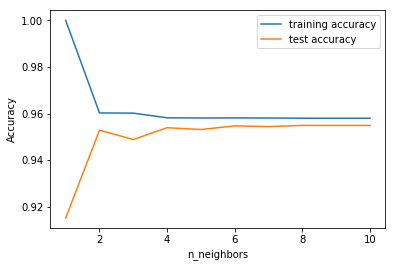

In [32]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    knn2 = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn2.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy.append(knn2.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy.append(knn2.score(X_test, Y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

# Decision Tree

In [82]:
dt = DecisionTreeClassifier(criterion='entropy',min_samples_split=20, random_state=99)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [94]:
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file="treedt.dot", impurity=False, filled=True)

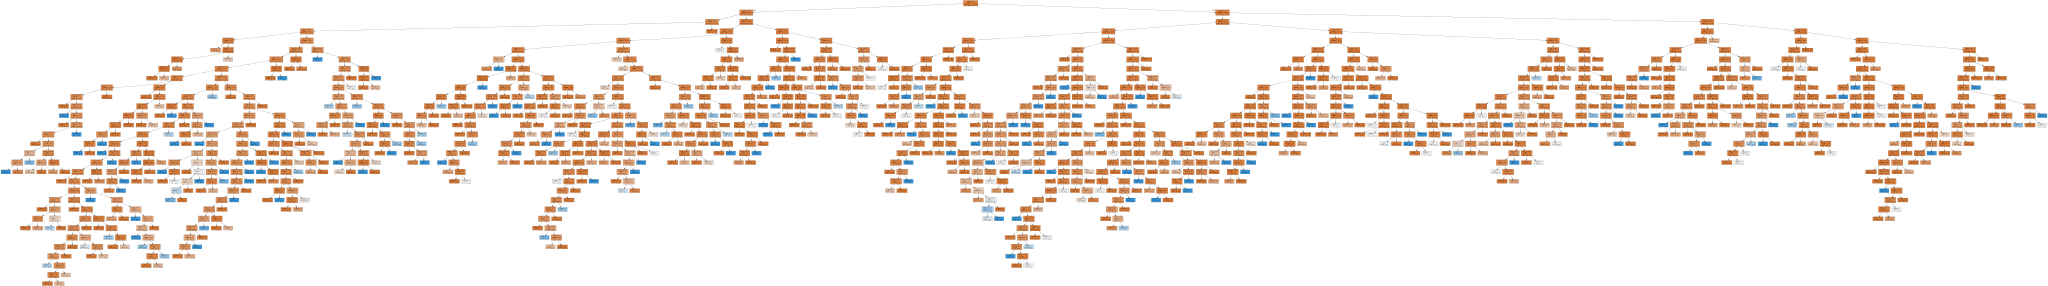

In [95]:
import graphviz

with open("treedt.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [84]:
cmdt = confusion_matrix(Y_test, preds)
cmdt

array([[9547,  231],
       [ 446,   16]], dtype=int64)

In [85]:
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, Y_test)))

Accuracy on training set: 0.971
Accuracy on test set: 0.934


In [86]:
dt1 = DecisionTreeClassifier(criterion='entropy',max_depth=5, min_samples_split=20, random_state=99)
dt1.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [88]:
from sklearn.cross_validation import KFold
crossvalidation = KFold(n=X_train.shape[0], n_folds=10, shuffle=True, random_state=1)

In [89]:
from sklearn.cross_validation import cross_val_score
scoredt1 = np.mean(cross_val_score(dt1, X_train, Y_train, scoring='accuracy', cv=crossvalidation, n_jobs=1))
scoredt1

0.9576499156699729

In [90]:
dt1.feature_importances_

array([0.        , 0.        , 0.        , 0.33494943, 0.        ,
       0.03305554, 0.        , 0.01717545, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04902068, 0.        , 0.        , 0.        ,
       0.0211092 , 0.        , 0.        , 0.01888965, 0.        ,
       0.        , 0.09153075, 0.        , 0.        , 0.        ,
       0.01598365, 0.04054582, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04554512, 0.        ,
       0.        , 0.09270857, 0.06158101, 0.        , 0.03539218,
       0.06351906, 0.0561083 , 0.        , 0.        , 0.0228856 ])

In [93]:
print("Accuracy on training set: {:.3f}".format(dt1.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(dt1.score(X_test, Y_test)))

Accuracy on training set: 0.958
Accuracy on test set: 0.955


# Radom Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=5)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
y_predrf = rf.predict(X_test)

In [56]:
from sklearn.metrics import accuracy_score 
accuracy_score(Y_test, y_predrf, normalize=True, sample_weight=None)

0.9548828125

In [62]:
rnd_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train,Y_train)
for name, importance in zip(feature_names, rnd_clf.feature_importances_):
    print(name, "=", importance)

customer_no = 0.013153680774493437
feature_1 = 0.04973314696481423
feature_3 = 0.009946437399762323
feature_4 = 0.04875942048391203
feature_7 = 0.004363017612535523
feature_11 = 0.013251902587704692
feature_12 = 0.0032987738529352568
feature_19 = 0.006145487240941996
feature_23 = 0.009437747669184402
feature_25 = 0.012570105320066598
feature_26 = 0.011725996113087516
feature_27 = 0.01650667315927125
feature_28 = 0.008979957124505807
feature_31 = 0.013408837436383986
feature_32 = 0.004754665594160548
feature_33 = 0.004656525461381802
feature_34 = 0.031232479575925648
feature_35 = 0.019305777191219346
feature_36 = 0.013013388965093499
feature_37 = 0.0544296981282262
feature_38 = 0.024775576451047342
feature_40 = 0.024492902576954752
feature_41 = 0.0039711671373114845
feature_42 = 0.01906667668842803
feature_43 = 0.00483341560003183
feature_46 = 0.005634916785264881
feature_50 = 0.019181601413073505
feature_52 = 0.004468392537671293
feature_55 = 0.01382963151688384
feature_56 = 0.00099398

In [63]:
features = feature_names
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

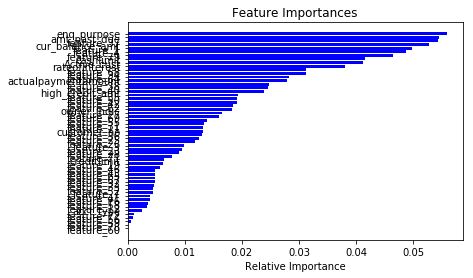

In [64]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Gradient Boosted Trees (Gradient Boosting Machines)

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [34]:
y_predgbrt = gbrt.predict(X_test)

In [36]:
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, Y_test)))

Accuracy on training set: 0.959
Accuracy on test set: 0.955


In [40]:
from sklearn.ensemble import GradientBoostingClassifier
gbm5 = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0,\
                                     max_depth=5, random_state=0).fit(X_train,Y_train)

In [96]:
print("Accuracy on training set: {:.3f}".format(gbm5.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(gbm5.score(X_test, Y_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.927


In [41]:
train_prediction = gbm5.predict_proba(X_train)
test_prediction = gbm5.predict_proba(X_test)

In [42]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(np.array(Y_train),\
                                                           np.array(train_prediction[:,1]), pos_label=1)

In [43]:
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(np.array(Y_test),\
                                                        np.array(test_prediction[:,1]), pos_label=1)

Text(0,0.5,'True Positive Rate')

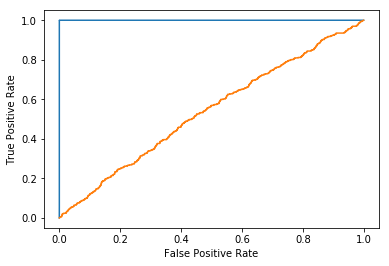

In [44]:
plt.plot(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Multi-Layer Perceptrons

In [45]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, Y_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.938


In [46]:
y_predmlp = mlp.predict(X_test)
cmmlp = confusion_matrix(Y_test, y_predmlp)
cmmlp

array([[9592,  186],
       [ 452,   10]], dtype=int64)

In [51]:
mlp3 = MLPClassifier(solver='lbfgs', activation='tanh',
                    random_state=0, hidden_layer_sizes=[10, 10])
mlp3.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(mlp3.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(mlp3.score(X_test, Y_test)))

Accuracy on training set: 0.965
Accuracy on test set: 0.948


In [52]:
y_predmlp3 = mlp3.predict(X_test)
cmmlp3 = confusion_matrix(Y_test, y_predmlp3)
cmmlp3

array([[9697,   81],
       [ 455,    7]], dtype=int64)

# Support Vector Machine (SVM)

In [97]:
from sklearn.svm import SVC
svm1 = SVC(kernel='rbf', C=10, gamma=0.1).fit(X_train, Y_train)

In [98]:
y_predsvm1 = svm1.predict(X_test)

In [99]:
cmsvm1 = confusion_matrix(Y_test, y_predsvm1)
cmsvm1

array([[9757,   21],
       [ 459,    3]], dtype=int64)

In [100]:
print("Training set score: {:.3f}".format(svm1.score(X_train, Y_train)))
print("Test set score: {:.3f}".format(svm1.score(X_test, Y_test)))

Training set score: 1.000
Test set score: 0.953


In [ ]:
# Below grid search is taking time to compute so not running

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = svm1,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [ ]:
best_accuracy

In [ ]:
best_parameters

# PCA- Principal Component Analysis

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [102]:
explained_variance

array([6.70475134e-02, 5.23483297e-02, 5.03633646e-02, 4.66008863e-02,
       3.86629921e-02, 3.83997725e-02, 3.61744083e-02, 3.58679020e-02,
       3.50971708e-02, 3.21384988e-02, 2.96870301e-02, 2.65888768e-02,
       2.56324183e-02, 2.25231621e-02, 2.03249820e-02, 1.95748376e-02,
       1.90692508e-02, 1.86655289e-02, 1.83980672e-02, 1.82813794e-02,
       1.80975589e-02, 1.80144537e-02, 1.79892783e-02, 1.77583824e-02,
       1.74506468e-02, 1.73474325e-02, 1.70721150e-02, 1.65527647e-02,
       1.65285707e-02, 1.59957719e-02, 1.57093692e-02, 1.50438084e-02,
       1.43437919e-02, 1.36082113e-02, 1.21923445e-02, 1.19280940e-02,
       1.14519184e-02, 1.07854415e-02, 1.06455904e-02, 1.00692288e-02,
       9.69485088e-03, 8.01331826e-03, 5.36083005e-03, 5.01196837e-03,
       4.58818595e-03, 4.42731440e-03, 4.00033407e-03, 3.78478126e-03,
       2.99195691e-03, 1.44774537e-03, 6.46802678e-04, 7.66800136e-07,
       5.65576405e-32, 2.78948766e-32, 3.91269744e-33])

# Results
### Following are the improved solution for prediction
- K-Neigors
- Decision Tree
- MLP